# Sale Prediction

In [282]:
import pandas as pd
import numpy as np
from datetime import datetime, date

In [283]:
# load data
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("sales_train.csv")

From the competition, it wants the final result to be item id and the item count per month. The prediction primarily depends on item_price item_id and item_cnt_day. Firstly, we need to clean the data.

In [284]:
train = train.drop(columns=['date', 'item_price'])


In [285]:
train = pd.merge(train,test, on=['shop_id', 'item_id'])

In [286]:
train = train.drop(columns=['shop_id','item_id'])

In [287]:
train = train.sort_values(['ID', 'date_block_num'])

In [288]:
train.head()

,date_block_num,item_cnt_day,ID
896436,20,1.0,0
896437,22,1.0,0
896438,23,1.0,0
896439,23,1.0,0
896440,24,1.0,0


In [289]:
train.max()

date_block_num        33.0
item_cnt_day        2169.0
ID                214199.0
dtype: float64

In [290]:
train_by_month = train.groupby(['ID', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})

In [291]:
train_by_month.head()

,ID,date_block_num,item_cnt_day
0,0,20,1.0
1,0,22,1.0
2,0,23,2.0
3,0,24,2.0
4,0,28,1.0


In [292]:
train_by_month_short = train_by_month.loc[train_by_month['ID']<=214199]
train_by_month_short.head()

,ID,date_block_num,item_cnt_day
0,0,20,1.0
1,0,22,1.0
2,0,23,2.0
3,0,24,2.0
4,0,28,1.0


In [293]:
print(len(train_by_month_short))

600159


In [294]:
uniq_ID = train_by_month_short.ID.unique()
uniq_ID = np.array(["%d" % w for w in uniq_ID.reshape(uniq_ID.size)])
dic = {elem : pd.DataFrame for elem in uniq_ID}
for key in dic.keys():
    dic[key] = train_by_month_short[:][train_by_month_short.ID == int(key)]

In [295]:
for i in dic.keys():
    dic[i] = dic[i].sort_values('date_block_num')
    for j in range(34):
        if j not in dic[i].date_block_num.unique():
            dic[i] = dic[i].append({'ID': i, 'date_block_num': j}, ignore_index=True)
        

Check if the dataset is clean:

In [296]:
train.isna().sum()

date_block_num    0
item_cnt_day      0
ID                0
dtype: int64

In [297]:
train.dtypes

date_block_num      int64
item_cnt_day      float64
ID                  int64
dtype: object

Then group the data to get what we need to predict:

In [298]:
missing_list = []
for i in range(0,214200):
    if str(i) not in dic.keys():
        missing_list.append(i)
#missing_list

In [299]:
len(missing_list)

102796

In [300]:
not_in_market_list = []
for i in list(dic.keys()):
    if dic[i]['item_cnt_day'].loc[28:33].isna().sum() == 6:
        not_in_market_list.append(int(i))
        del dic[i]
        assert i not in dic.keys()
#not_in_market_list

In [301]:
len(not_in_market_list)

110535

In [304]:
len(dic)

869

In [305]:
new_to_market_dict = dict()
for i in list(dic.keys()):
    if dic[i]['item_cnt_day'].loc[0:27].isna().sum() == 28 and dic[i]['item_cnt_day'].loc[28,33].isna().sum() != 6:
        new_to_market_dict[int(i)] = dic[i]['item_cnt_day'].loc[28,33].mean()
        del dic[i]
        assert i not in dic.keys()
#new_to_market_dict

In [306]:
len(new_to_market_dict)

0

In [307]:
dic.keys()

dict_keys(['42', '43', '415', '460', '921', '973', '1291', '5143', '5185', '5374', '5496', '5515', '5560', '6159', '6189', '6305', '6391', '9020', '9844', '10222', '10227', '10241', '10242', '10243', '10408', '10474', '10495', '10596', '10615', '10620', '10660', '10761', '11121', '11259', '11289', '11337', '11405', '11447', '11467', '12823', '14120', '14944', '15342', '15343', '15508', '15760', '16505', '17923', '20442', '20484', '20485', '20486', '20815', '20830', '20860', '21321', '21459', '21667', '25522', '25527', '25542', '25543', '25584', '25585', '25586', '25708', '25718', '25774', '25896', '25915', '25960', '26049', '26052', '26421', '26473', '26485', '26589', '26637', '26705', '26767', '27528', '28123', '30244', '30643', '31015', '31060', '31521', '31689', '36195', '36298', '36300', '36303', '36621', '36951', '37296', '37319', '37325', '37341', '37350', '38839', '40822', '40827', '40841', '40842', '40843', '40884', '40885', '40886', '40897', '40914', '41008', '41018', '41031',

In [308]:
for i in list(dic.keys()):
    dic[i]['item_cnt_day'] = dic[i]['item_cnt_day'].interpolate()

In [309]:
from statsmodels.tsa.arima_model import ARIMA

In [310]:
time_series_dict = dict()
for i in list(dic.keys()):
    ts = dic[i]['item_cnt_day']
    model = ARIMA(ts, order=(1, 1, 0))
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(ts), len(ts),  typ='levels')
    time_series_dict[int(i)] = yhat
time_series_dict

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provide

{42: 34    4.137739
 dtype: float64, 43: 34    2.986878
 dtype: float64, 415: 34    3.955551
 dtype: float64, 460: 34    43.604598
 dtype: float64, 921: 34    0.988381
 dtype: float64, 973: 34    0.959718
 dtype: float64, 1291: 34    0.960173
 dtype: float64, 5143: 34    3.800517
 dtype: float64, 5185: 34    1.975709
 dtype: float64, 5374: 34    25.331223
 dtype: float64, 5496: 34    8.149477
 dtype: float64, 5515: 34    3.737555
 dtype: float64, 5560: 34    101.325325
 dtype: float64, 6159: 34    2.659736
 dtype: float64, 6189: 34    2.903392
 dtype: float64, 6305: 34    0.839879
 dtype: float64, 6391: 34    0.812074
 dtype: float64, 9020: 34    0.778658
 dtype: float64, 9844: 34    0.387383
 dtype: float64, 10222: 33    5.84359
 dtype: float64, 10227: 34    0.814296
 dtype: float64, 10241: 34    7.227413
 dtype: float64, 10242: 34    7.156678
 dtype: float64, 10243: 33    14.889031
 dtype: float64, 10408: 34    2.996795
 dtype: float64, 10474: 33    18.280126
 dtype: float64, 10495: 

In [311]:
len(time_series_dict)

869

In [324]:
time_series_dict[43]

34    2.986878
dtype: float64

In [313]:
869+102796+110535

214200

In [342]:
time_series_dict.keys()

dict_keys([42, 43, 415, 460, 921, 973, 1291, 5143, 5185, 5374, 5496, 5515, 5560, 6159, 6189, 6305, 6391, 9020, 9844, 10222, 10227, 10241, 10242, 10243, 10408, 10474, 10495, 10596, 10615, 10620, 10660, 10761, 11121, 11259, 11289, 11337, 11405, 11447, 11467, 12823, 14120, 14944, 15342, 15343, 15508, 15760, 16505, 17923, 20442, 20484, 20485, 20486, 20815, 20830, 20860, 21321, 21459, 21667, 25522, 25527, 25542, 25543, 25584, 25585, 25586, 25708, 25718, 25774, 25896, 25915, 25960, 26049, 26052, 26421, 26473, 26485, 26589, 26637, 26705, 26767, 27528, 28123, 30244, 30643, 31015, 31060, 31521, 31689, 36195, 36298, 36300, 36303, 36621, 36951, 37296, 37319, 37325, 37341, 37350, 38839, 40822, 40827, 40841, 40842, 40843, 40884, 40885, 40886, 40897, 40914, 41008, 41018, 41031, 41095, 41097, 41133, 41196, 41205, 41215, 41220, 41230, 41260, 41326, 41332, 41352, 41361, 41400, 41440, 41471, 41477, 41561, 41655, 41657, 41675, 41685, 41721, 41785, 41846, 41859, 41889, 41937, 42005, 42036, 42047, 42064, 4

In [410]:
import statsmodels.api as sm

In [414]:
vis_42 = sm.tsa.seasonal_decompose(dic['42']['item_cnt_day'],freq=12,model="additive")

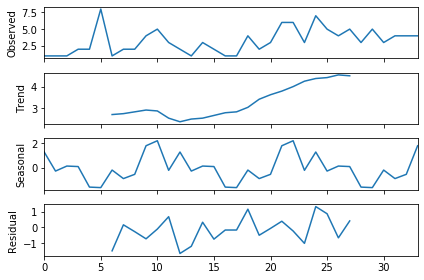

In [416]:
plot_42 = vis_42.plot()
plot_42.show()

In [419]:
vis_42_mult = sm.tsa.seasonal_decompose(dic['42']['item_cnt_day'],freq=12,model="multiplicative")

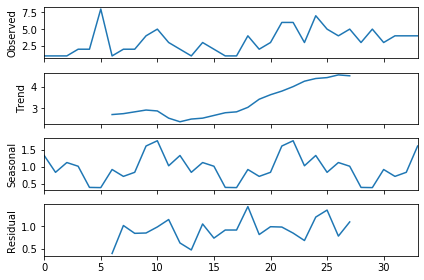

In [420]:
plot_42_mult = vis_42_mult.plot()
plot_42_mult.show()

In [421]:
vis_43 = sm.tsa.seasonal_decompose(dic['43']['item_cnt_day'],freq=12,model="additive")

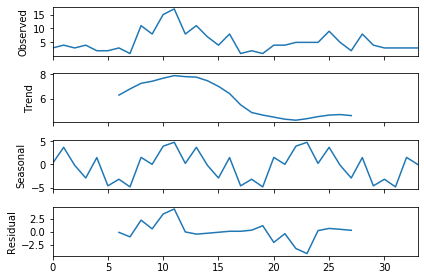

In [422]:
plot_43 = vis_43.plot()
plot_43.show()

In [388]:
#test = test.drop(['item_cnt_month'],axis=1)

In [389]:
test['item_cnt_month'] = 0

In [395]:
test = test.astype({'item_cnt_month': 'float'})

In [396]:
test.dtypes

ID                  int64
shop_id             int64
item_id             int64
item_cnt_month    float64
dtype: object

In [397]:
for i in time_series_dict.keys():
    test['item_cnt_month'][i] = float(time_series_dict[i])

/home/wangqingxu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [398]:
test['item_cnt_month'].notna().sum()

214200

In [399]:
test.loc[43]

ID                  43.000000
shop_id              5.000000
item_id           5822.000000
item_cnt_month       2.986878
Name: 43, dtype: float64

In [400]:
test['item_cnt_month'].astype('float32')

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
214195    0.0
214196    0.0
214197    0.0
214198    0.0
214199    0.0
Name: item_cnt_month, Length: 214200, dtype: float32

In [407]:
test = test.drop(['shop_id','item_id'],axis=1)

In [426]:
test[test['item_cnt_month'] != 0]

,ID,item_cnt_month
42,42,4.137739
43,43,2.986878
415,415,3.955551
460,460,43.604598
921,921,0.988381
973,973,0.959718
1291,1291,0.960173
5143,5143,3.800517
5185,5185,1.975709
5374,5374,25.331223


In [430]:
test.to_csv(r'my_prediction.csv',index=False)